In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats

In [2]:
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [4]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, roc_auc_score,precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score

In [5]:
#!pip install imblearn 

In [6]:
seed = 42
np.random.seed(seed)

# Import Merged Data

In [7]:
cm = pd.read_csv('cleaned_and_merged_data.csv')

In [8]:
cm.head()

,LPERMNO,sic,fyear,oancf/sale,ebitda/sale,gp/sale,ros,gross_margin,oancf/seq,oancf/at,ebit/seq,ebit/at,ebitda/at,roe,roa,xint/sale,effective_tax_rate,fin_lev,dltt/seq,dltt/at,wcap/at,ch/at,at/lt,lt/at,invt/at,asset_turnover,invt_turnover,invt/sale,receivable_turnover,payable_turnover,bankrupt,bankrupt_year,CPI,GDP,inflation,unemployment,spread
3,10031,Retail Trade,1987.0,-0.026421,0.002971,0.363770,0.004979,0.363770,-0.129138,-0.061526,-0.052990,-0.025246,0.006919,0.024336,0.011595,0.013438,0.421169,2.098914,0.716734,0.341479,0.301906,0.029610,1.909989,0.523563,0.743174,2.328637,1.993541,0.319146,29.507109,52.392707,0.0,1989.0,113.6,4855.2,0.0365,0.062,0.97704
4,10031,Retail Trade,1988.0,-0.064009,-0.112168,0.337966,-0.238905,0.337966,10.824742,-0.128993,22.536082,-0.268550,-0.226044,40.402062,-0.481450,0.022159,0.088499,-83.917526,-0.536082,0.006388,-0.052243,0.018550,0.988224,1.011916,0.717445,2.015233,1.859589,0.356011,15.273743,10.896048,0.0,1989.0,118.3,5236.4,0.0414,0.055,0.74760
9,54594,Wholesale Trade,1988.0,0.000231,0.125630,0.254218,0.061064,0.254218,0.000548,0.000264,0.260024,0.125186,0.143244,0.144621,0.069626,0.019217,0.329605,2.077113,0.149825,0.072131,0.317315,0.012809,1.928408,0.518562,0.393705,1.140208,2.159857,0.345292,4.267680,11.271809,0.0,2019.0,118.3,5236.4,0.0414,0.055,0.74760
10,54594,Wholesale Trade,1989.0,0.043543,0.121454,0.242639,0.057668,0.242639,0.102196,0.049858,0.247172,0.120588,0.139071,0.135348,0.066032,0.022453,0.327611,2.049724,0.381587,0.186165,0.415694,0.010409,1.952632,0.512129,0.417349,1.145048,2.077910,0.364482,4.753903,12.405538,0.0,2019.0,124.0,5641.6,0.0482,0.053,-0.07868
11,54594,Wholesale Trade,1990.0,0.079073,0.089932,0.215419,0.031725,0.215419,0.190378,0.097092,0.173916,0.088697,0.110425,0.076381,0.038954,0.021591,0.306777,1.960790,0.355835,0.181475,0.405477,0.004087,2.040810,0.490002,0.410922,1.227878,2.344411,0.334660,5.113461,13.284604,0.0,2019.0,130.7,5963.1,0.0540,0.056,0.39088


### Clean data a bit

In [9]:
cm['CPI'] = np.log10(cm['CPI'])
cm['GDP'] = np.log10(cm['GDP'])

# Lag one year ahead #

In [10]:
# year_lag = lag for x years 
# e.g. a row with 2018 data -- year_lag = 2 -- (2018) 2017 2016

def lag(data, year_lag = 2):

    # change the fyear to ascend within every LPERMNO
    data.sort_values(['LPERMNO', 'fyear'], ascending = [True, True], inplace = True)

    # remove irrelevant columns first
    df = data.drop(columns = ['bankrupt','bankrupt_year'])
    
    # get the columns
    columns = df.columns
    col_to_lag = columns[2:]

    # run the loops to create lag columns to the number of lagged year
    for lag in range(1, year_lag+1):
        for colname in col_to_lag:
            df[f'{colname}'+ '_lag' + f'{lag}'] = df[f'{colname}'].shift((lag-1))

    # add back the bankrupt info
    df['bankrupt'] = data['bankrupt']
    df['bankrupt_year'] = data['bankrupt_year']

    # keep the new lagged columns and remove the original one
    df.drop(col_to_lag, axis=1, inplace = True)

    # drop the first row of each LPERMNO after lagging one year
    df = df.groupby(['LPERMNO']).apply(lambda x: x.iloc[1:])
    df = df.set_index('LPERMNO').reset_index()    
    
    # identify the real bankrupt row
    for i in range(len(df)):
        if (df['bankrupt'][i] == 1) & (df['bankrupt_year'][i] - df['fyear_lag1'][i] == 1):
            df['bankrupt'][i] = 1
        else:
            df['bankrupt'][i] = 0

    df['predict_year'] = df['fyear_lag1']+1

    return df

# cmcm = lag(cm[cm['tic'] == 'TSLA'],2)
cmcm = lag(cm ,2)
cmcm.head()

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0,2017.0,1993.0
3,10001,"Transportation, Communications, Electric, Gas ...",1993.0,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0,2017.0,1994.0
4,10001,"Transportation, Communications, Electric, Gas ...",1994.0,0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.1

In [11]:
cmcm['bankrupt'].value_counts()

0.0    94082
1.0      272
Name: bankrupt, dtype: int64

In [12]:
cmcm[cmcm['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    93410
1.0      272
Name: bankrupt, dtype: int64

In [13]:
dummy_sic = pd.get_dummies(cmcm['sic'])

cmcm.drop(columns=['LPERMNO', 'sic', 'fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'], inplace = True)

cm1 = pd.concat([dummy_sic, cmcm], axis=1)

cm1

,"Agriculture, Forestry and Fishing",Construction,"Finance, Insurance and Real Estate",Manufacturing,Mining,Nonclassifiable,Retail Trade,Services,"Transportation, Communications, Electric, Gas and Sanitary service",Wholesale Trade,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt
0,0,0,0,0,0,0,0,0,1,0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0
1,0,0,0,0,0,0,0,0,1,0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0
2,0,0,0,0,0,0,0,0,1,0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0
3,0,0,0,0,0,0,0,0,1,0,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0
4,0,0,0,0,0,0,0,0,1,0,0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.142209,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418

# Oversampling and Undersampling

In [14]:
# Only supports Continuous Features
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE

    X = data.loc[:, data.columns != y_label]
    y = data[y_label]

    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed)

    X_res, y_res = sm.fit_resample(X, y)
    
    return X_res, y_res

# Supports Categorical and Continuous Features
def oversampling_nc(data, y_label, k = 5, seed = 1, cat_features = [None]):
    
    from imblearn.over_sampling import SMOTENC

    X = data.loc[:, data.columns != y_label]
    y = data[y_label]

    sm = SMOTENC(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, categorical_features = cat_features)

    X_res, y_res = sm.fit_resample(X, y)
    
    return X_res, y_res


def undersampling(data, y_label, n = 3):

    from imblearn.under_sampling import NearMiss

    X = data.loc[:, data.columns != y_label]
    y = data[y_label]

    nm = NearMiss(sampling_strategy = 'auto')

    X_res, y_res = nm.fit_resample(X, y)
    
    return X_res, y_res

In [15]:
print(cm1['bankrupt'].value_counts())

x, y = oversampling_nc(cm1, 'bankrupt', cat_features = list(range(0,10)))
cm1_smote = pd.merge(x, y, left_index = True, right_index = True)
cm1_smote['bankrupt'].value_counts()

0.0    94082
1.0      272
Name: bankrupt, dtype: int64


1.0    94082
0.0    94082
Name: bankrupt, dtype: int64

# Cross Validation 

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3)

model = LogisticRegression()
performance = cross_val_score(model, x_train, y_train, cv = 5)

performance

array([0.80682019, 0.80177148, 0.80132861, 0.81833481, 0.83417486])

## Base Model

In [17]:
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_test)

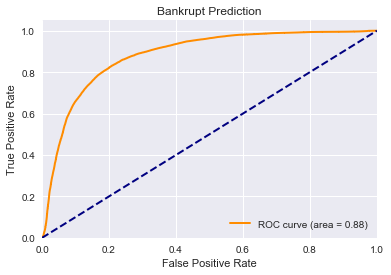

In [18]:
fpr,tpr,threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

(0, 1)

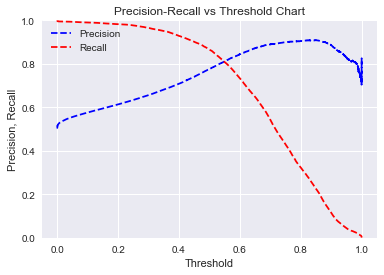

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
pr_auc = auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart") 
plt.plot(thresholds, precision[: -1], "b--", label="Precision") 
plt.plot(thresholds, recall[: -1], "r--", label="Recall") 
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

In [20]:
y_pred_binary = [1 if i >= 0.5 else 0 for i in y_pred[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

precision    recall  f1-score   support

         0.0    0.84749   0.75060   0.79611     65817
         1.0    0.77643   0.86509   0.81837     65898

    accuracy                        0.80788    131715
   macro avg    0.81196   0.80785   0.80724    131715
weighted avg    0.81194   0.80788   0.80724    131715



# Exploratory Data Analysis #

In [21]:
#! pip install pandas-profiling

In [22]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(cm1)
# profile.to_file(outputfile = 'Profile.html')
# profile